HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

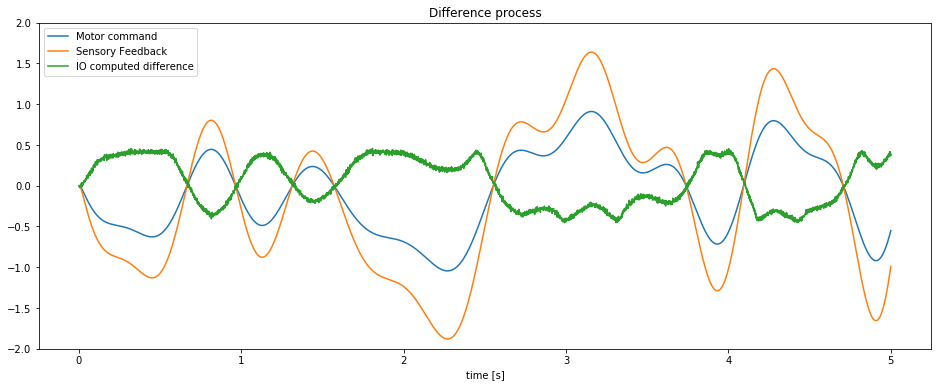

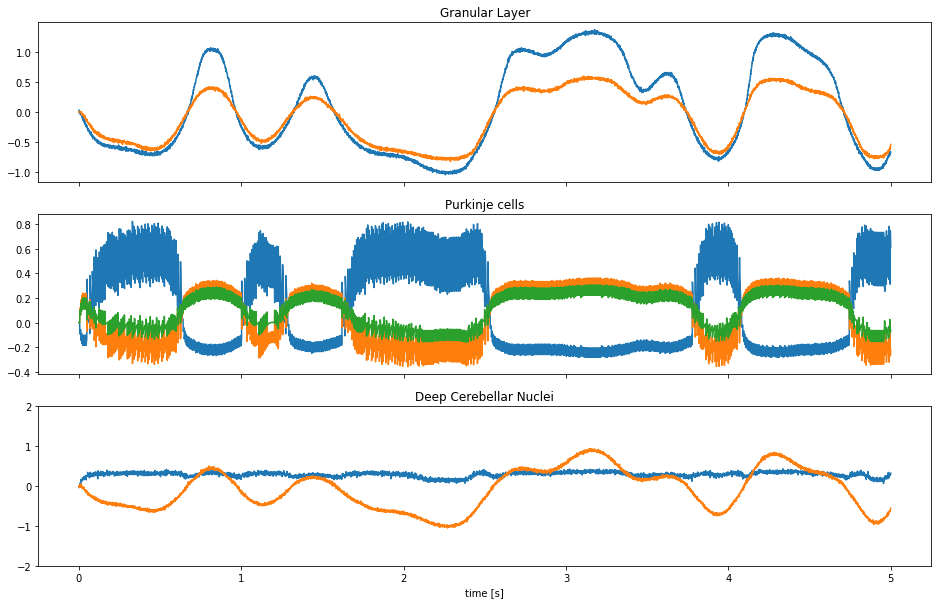

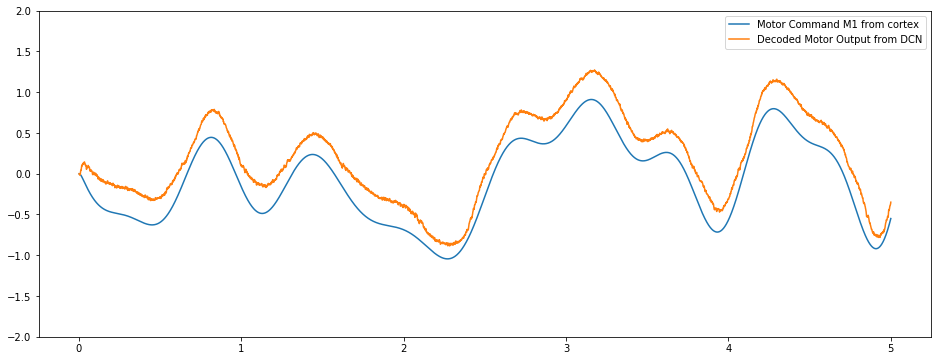

In [25]:
import nengo
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from nengo.utils.filter_design import cont2discrete





model = nengo.Network(label="Cerebellum")
with model:
    
    # parameters of motor input
    freq = 2  # frequency limit
    rms = 0.30  # amplitude of input (set to keep within [-1, 1])

    # simulation parameters
    dt = 0.001  # simulation timestep
    sim_t =100  # length of simulation
    seed = 0  # fixed for deterministic results

    # create the input signal (it would be trajectories later)
    MotorCommand = nengo.Node(
            output=nengo.processes.WhiteSignal(
                high=freq, period=sim_t, y0=0, seed=seed
            )
        )      

    SensoryFeedback = nengo.Node(
            output=nengo.processes.WhiteSignal(
                high=freq, period=sim_t, rms=3*rms, y0=0, seed=seed
            )
        )
    MotorOutput = nengo.Node(size_in=1)
    
    # Probe inputs and output
    MotorInProbe = nengo.Probe(MotorCommand, synapse = 0.01)
    SensoryProbe = nengo.Probe(SensoryFeedback, synapse = 0.01)
    MotorOutProbe = nengo.Probe(MotorOutput, synapse = 0.01)

    # Create inferior olive        
    IO = nengo.Network(label="Inferior Olive")
    with IO:

        # Create 3 ensembles each containing 100 leaky integrate-and-fire neurons
        A = nengo.Ensemble(100, dimensions=1)
        B = nengo.Ensemble(100, dimensions=1)
        DiffGroup = nengo.Ensemble(100, dimensions=1)

        # Connect the input nodes to the appropriate ensembles
        nengo.Connection(MotorCommand, A)
        nengo.Connection(SensoryFeedback, B)

        # Connect difference MC-SF
        nengo.Connection(A, DiffGroup)
        nengo.Connection(B, DiffGroup, transform = -1)   
        
        diffProbe = nengo.Probe(DiffGroup, synapse = 0.01)

    # Create Granular Layer (RNN)
    # The GrC represents the state of the integrator and the connections
    # define the dynamics of the integrator

    GcL = nengo.Network(label="Granular Layer")
    with GcL:                         

        GrC = nengo.Ensemble(n_neurons=200, dimensions=2)

        # Connect control value (Motor Command) and real value (Feedback)
        nengo.Connection(SensoryFeedback,GrC[0])
        nengo.Connection(MotorCommand,GrC[1])

        # Create recurrent connection with using a higher-dimensional mapping
        nengo.Connection(GrC, GrC[0],
                     function=lambda x: x[0] * x[1]) 
        
        GRCProbe = nengo.Probe(GrC, synapse = 0.01)

    # Purkinje Layer 
    
    PL = nengo.Network(label="Purkinje Cells Layer")
    with PL:
        Pc = nengo.Ensemble(n_neurons=2, dimensions=3)
        CFconnection = nengo.Connection(DiffGroup,Pc[0])
        MFconnection = nengo.Connection(GrC,Pc[1:])
        
        # Probe
        PCProbe = nengo.Probe(Pc, synapse = 0.01)
        
    # Deep Cerebellar Nuclei
    DCN = nengo.Network(label="Deep Cerebellar Nuclei")
    with DCN:
        DcN = nengo.Ensemble(100,dimensions=2)
        
        # Connect MF and PC to DCN
        nengo.Connection(Pc,DcN[0],transform = [[1,1,1]])
        nengo.Connection(MotorCommand,DcN[1])
        # Connect to motor MotorOutput
        nengo.Connection(DcN,MotorOutput,transform = [[1,1]])
        
        # Probe
        DCNProbe = nengo.Probe(DcN,synapse = 0.01)
 

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(5)
    
t = sim.trange()
# Plot section
# Motor command, Feedback and difference
plt.figure(figsize=(16, 6))
plt.plot(t, sim.data[MotorInProbe],label = "Motor command")
plt.plot(t, sim.data[SensoryProbe],label = "Sensory Feedback")
plt.plot(t, sim.data[diffProbe],label = "IO computed difference")
plt.title('Difference process')
plt.legend()
plt.ylim(-2,2);
plt.xlabel('time [s]')

# GrC, PL, DCN
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True,figsize=(16,10))
ax1.plot(t, sim.data[GRCProbe])
ax1.title.set_text("Granular Layer")
plt.ylim(-2,2);

ax2.plot(t, sim.data[PCProbe])
ax2.title.set_text("Purkinje cells")
plt.ylim(-2,2);

ax3.plot(t, sim.data[DCNProbe])
ax3.title.set_text("Deep Cerebellar Nuclei")
plt.xlabel('time [s]')
plt.ylim(-2,2);

# DCN motor output and Motor Command
plt.figure(figsize=(16, 6))
plt.plot(t, sim.data[MotorInProbe], label="Motor Command M1 from cortex")
plt.plot(t, sim.data[MotorOutProbe], label="Decoded Motor Output from DCN")
plt.legend();
plt.ylim(-2,2);
